✅ Loaded sign_text.png  —  Size: 460x342


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128196 (\N{PAGE FACING UP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


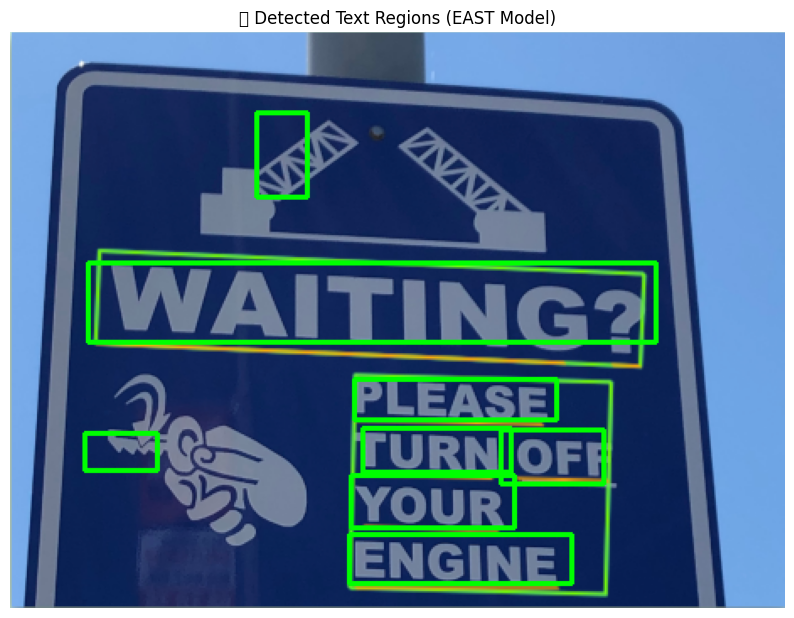

In [3]:
# ========================================
# 📘 TEXT DETECTION on sign_text.png using EAST
# ========================================

# Step 1: Install dependencies
!pip install opencv-python-headless matplotlib --quiet

# Step 2: Import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Step 3: Set the image path
image_path = "/content/sign_text.png"

# Step 4: Read the image
image = cv2.imread(image_path)
if image is None:
    raise ValueError("❌ Could not read sign_text.png — ensure it’s in /content/")
orig = image.copy()
(H, W) = image.shape[:2]
print(f"✅ Loaded sign_text.png  —  Size: {W}x{H}")

# Step 5: Download EAST model if not present
if not os.path.exists("frozen_east_text_detection.pb"):
    !wget -q https://github.com/oyyd/frozen_east_text_detection.pb/raw/master/frozen_east_text_detection.pb
    print("✅ EAST model downloaded.")

# Step 6: Prepare input blob for EAST
newW, newH = (320, 320)
rW, rH = (W / float(newW), H / float(newH))
blob = cv2.dnn.blobFromImage(cv2.resize(image, (newW, newH)), 1.0,
                             (newW, newH), (123.68, 116.78, 103.94),
                             swapRB=True, crop=False)

# Step 7: Load EAST model
net = cv2.dnn.readNet("frozen_east_text_detection.pb")
layerNames = ["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"]

# Step 8: Forward pass
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)

# Step 9: Decode predictions
def decode_predictions(scores, geometry, confThreshold=0.5):
    numRows, numCols = scores.shape[2:4]
    rects, confidences = [], []
    for y in range(numRows):
        scoresData = scores[0, 0, y]
        xData0, xData1, xData2, xData3, anglesData = [geometry[0, i, y] for i in range(5)]
        for x in range(numCols):
            if scoresData[x] < confThreshold:
                continue
            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            angle = anglesData[x]
            cos, sin = np.cos(angle), np.sin(angle)
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX, startY = int(endX - w), int(endY - h)
            rects.append((startX, startY, endX, endY))
            confidences.append(float(scoresData[x]))
    return rects, confidences

(rects, confidences) = decode_predictions(scores, geometry)

# Step 10: Apply Non-Maximum Suppression
indices = cv2.dnn.NMSBoxes(
    [cv2.boundingRect(np.array([[r[0], r[1]], [r[2], r[3]]])) for r in rects],
    confidences, 0.5, 0.4
)

# Step 11: Draw detected boxes
if len(indices) > 0:
    for i in indices.flatten():
        (startX, startY, endX, endY) = rects[i]
        startX, startY = int(startX * rW), int(startY * rH)
        endX, endY = int(endX * rW), int(endY * rH)
        cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

# Step 12: Display result
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
plt.title("📄 Detected Text Regions (EAST Model)")
plt.axis("off")
plt.show()
